In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
import numpy as np
import gensim
from gensim.models import Word2Vec
from gensim import corpora, models, similarities, downloader

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/taru/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
print("Downloading word2vec model")
word2vec_model = gensim.downloader.load('word2vec-google-news-300')

In [6]:
from nltk.tokenize import word_tokenize

In [7]:
def tokenize(text):
    text = text.lower()
    tokens = word_tokenize(text)
    return tokens

In [8]:
def wordToVector(word, model):
    try:
        return model[word]
    except KeyError:
        # Handle out-of-vocabulary words
        return np.zeros(model.vector_size)  # Return zero vector for OOV words

In [9]:
def textToVectors(text, model):
    tokens = tokenize(text)  # Tokenize the text
    vectors = [wordToVector(token, model) for token in tokens]  # Convert words to vectors
    vectors = np.array(vectors)
    return vectors

Creating a skip connection auto-encoder architecture. 

In [10]:
class SkipConnectionEncoder(nn.Module):

    def __init__(self, input_shape, compression_size):

        super().__init__()

        # Assuming the embeddings are of dimensions 300 and each sentence has 10 words/tokens
        num_of_words = input_shape[0]
        embedding_dim = input_shape[1]

        # Calculate the input size for the MLP
        mlp_input_size = embedding_dim * num_of_words

        # Define layers for the encoder
        self.layer1 = nn.Linear(mlp_input_size, 2400)
        self.layer2 = nn.Linear(2400, 1500)
        self.layer3 = nn.Linear(1500, compression_size)
        
        # Activation function
        self.relu = nn.ReLU()
        


    def forward(self, features):

        # Flatten the input features
        features_flat = features.flatten()

        # features_flat = torch.tensor(features_flat, dtype=torch.float32)
        
        # Pass through the first layer
        out1 = self.layer1(features_flat)
        a1 = self.relu(out1)
        
        # Pass through the second layer
        out2 = self.layer2(a1)
        a2 = self.relu(out2)

        # Pass through the third layer
        out3 = self.layer3(a2)
    
        # Return the outputs of each layer
        return out3, out2, out1


In [11]:
class SkipConnectionDecoder(nn.Module):

    def __init__(self, input_size, output_shape):
        super().__init__()

        self.output_shape = output_shape

        num_of_words = output_shape[0]
        embedding_dim = output_shape[1]

        # Calculate the output size for the MLP
        mlp_output_size = embedding_dim * num_of_words

        # Define layers for the decoder
        self.layer1 = nn.Linear(input_size, 1500)
        self.layer2 = nn.Linear(1500, 2400)
        self.layer3 = nn.Linear(2400, mlp_output_size)
        
        # Activation function
        self.relu = nn.ReLU()


    def forward(self, x1, x2, x3):

        # Pass through the first layer
        out1 = self.layer1(x1)
        a1 = self.relu(out1)

        # Skip connection: add input from previous layer and pass through the second layer
        out2 = self.layer2(a1 + x2)
        a2 = self.relu(out2)

        # Skip connection: add input from previous layer and pass through the third layer
        out3 = self.layer3(a2 + x3)

        # Reshape the final output into a 300-dimensional embedding for 10 words
        out = out3.view(self.output_shape[0], self.output_shape[1])

        return out

In [12]:
class Autoencoder(nn.Module):
    
    def __init__(self, input_shape, compression_size):
        super().__init__()
        
        self.input_size = input_shape

        self.encoder = SkipConnectionEncoder(input_shape, compression_size)
        self.decoder = SkipConnectionDecoder(compression_size, input_shape)
        self.relu = nn.ReLU()
        
        

    def forward(self, features):

        # implementing auto-encoder.
        
        encoded, _ , _ = self.encoder(features)
        activatedEncoded = self.relu(encoded)
        # in order to implement variational auto-encoders, the forward pass should return the mean and the variance as well.
        # this will in turn be passed to the loss function which uses them to calculate the kl divergence.
        decoded = self.decoder(activatedEncoded, 0, 0)

        # out1 is the output for the encoder, out2 is the output for the decoder.
        
        return decoded, encoded

In [74]:
# testing that the autoencoder works.

dummy_vector = textToVectors("The quick brown fox jumped. Over the lazy, brown Dog!", word2vec_model)

print(dummy_vector.shape)

autoencoder = Autoencoder(dummy_vector.shape, 900)
decoded, encoded = autoencoder(torch.tensor(dummy_vector).float())

print(decoded)
print(decoded.shape)

print(encoded)
print(encoded.shape)

reshaped_encoded = encoded.view(3, 300)
print(reshaped_encoded.shape)

# pass the reshaped_encoded to a vector to word to see what words get produced in the compression layer.



(13, 300)
tensor([[-0.0283,  0.0053, -0.0251,  ...,  0.0180, -0.0127,  0.0172],
        [-0.0123, -0.0030, -0.0252,  ...,  0.0038,  0.0143, -0.0114],
        [-0.0005,  0.0066,  0.0160,  ..., -0.0108, -0.0147,  0.0153],
        ...,
        [ 0.0019, -0.0104,  0.0061,  ..., -0.0144, -0.0100, -0.0185],
        [ 0.0156, -0.0135, -0.0190,  ..., -0.0001,  0.0024, -0.0048],
        [-0.0111, -0.0171,  0.0168,  ..., -0.0294, -0.0014,  0.0034]],
       grad_fn=<ViewBackward0>)
torch.Size([13, 300])
tensor([ 2.8519e-02, -2.1042e-02, -1.8555e-02, -5.5807e-03,  1.2468e-02,
         2.2315e-03,  2.0965e-03, -1.2499e-03,  6.0861e-03,  1.5911e-02,
         4.1068e-02, -1.8818e-02, -2.7332e-02, -5.0532e-02,  4.3839e-02,
        -1.9399e-02,  2.3222e-02, -1.2101e-02,  2.7841e-03,  1.4913e-03,
        -1.2275e-03,  3.0557e-02, -1.7421e-02,  2.2639e-02,  1.0563e-02,
         2.1042e-02,  6.2973e-04, -1.8636e-02,  1.7675e-02, -6.6244e-03,
         1.8061e-02, -6.6992e-03,  6.7019e-03,  1.3053e-02,  1.7

/var/folders/y6/g654jn8x2pb_10qhh6pnnbzr0000gn/T/ipykernel_21265/3185637845.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_flat = torch.tensor(features_flat, dtype=torch.float32)


In [13]:
def vectorsToText(embeddings, word2vec_model):
    
    words = []
    for vector in embeddings:
        vector_np = vector.detach().numpy()
        # Normalize the vector to have unit length
        normalized_vector = vector_np / np.linalg.norm(vector_np)
        try:
            # Find the most similar word to the given normalized vector
            similar_word = word2vec_model.most_similar(positive=[normalized_vector], topn=1)[0][0]
            words.append(similar_word)
        except KeyError:
            # If the normalized vector doesn't correspond to any word, append error message
            words.append("UNKNOWN_WORD")
    return words


In [47]:
test_vectors = textToVectors("The quick brown fox jumped. Over the lazy, brown Dog!", word2vec_model)
test_words = vectorsToText(torch.tensor(test_vectors), word2vec_model)

print(test_words)


/var/folders/y6/g654jn8x2pb_10qhh6pnnbzr0000gn/T/ipykernel_24290/2271388024.py:16: RuntimeWarning: invalid value encountered in divide
  normalized_vector = vector_np / np.linalg.norm(vector_np)


['the', 'quick', 'brown', 'fox', 'jumped', '</s>', 'over', 'the', 'lazy', '</s>', 'brown', 'dog', '</s>']


In [59]:
words = vectorsToText(reshaped_encoded, word2vec_model)

print(words)

['Meiya', 'Leezza', 'Shiias']


In [18]:
import datasets
from torch.utils.data import Dataset, DataLoader

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
dataset = datasets.load_dataset("cnn_dailymail", '3.0.0')

In [20]:
class MyDataset(Dataset):
    def __init__(self, dataset):
        self.articles = dataset['train']['article']
        self.summaries = dataset['train']['highlights']

    def __len__(self):
        return len(self.articles)

    def __getitem__(self, idx):
        # Extract the article and summary from the dataset
        article = self.articles[idx]
        summary = self.summaries[idx]
        return article, summary

# Instantiate your custom dataset using only the training set
custom_dataset = MyDataset(dataset)

# Create a PyTorch DataLoader
batch_size = 1
dataloader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

print("Length of DataLoader:", len(dataloader))
print("Length of Custom Dataset:", len(custom_dataset))

Length of DataLoader: 287113
Length of Custom Dataset: 287113


In [21]:
from sklearn.decomposition import PCA

In [22]:
def compressVectorsPCA(data, target_count):
    pca = PCA(n_components=target_count)
    compressed_data = pca.fit_transform(data.T).T
    return compressed_data

In [39]:
def autoencoder_training(model, loss_function, optimizer, train_data, n_epochs, update_interval):
    
    losses = []

    for epoch in range(n_epochs):

        epoch_loss = 0.0
        batch_count = 0
        index = 0

        for articles, summaries in train_data:

            print(f"Batch {index}")

            index += 1
            
            optimizer.zero_grad()

            # Convert articles to embeddings
            article_embedding = textToVectors(articles[0], word2vec_model)

            compressed_vector = compressVectorsPCA(article_embedding, 13)

            decoded, encoded = model(torch.tensor(compressed_vector).float())

            # Calculate loss
            loss = loss_function(decoded, torch.tensor(compressed_vector).float())

            # Backpropagation
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1

            # Logging and updating losses
            if batch_count % update_interval == 0:
                losses.append(epoch_loss / batch_count)

        epoch_loss /= len(train_data)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")

    return model, losses


In [24]:
from torch.utils.data import SubsetRandomSampler

In [25]:
subset_sampler = SubsetRandomSampler(range(100))

# Create a PyTorch DataLoader for the subset
subset_dataloader = DataLoader(custom_dataset, batch_size=batch_size, sampler=subset_sampler)

print("Length of Subset DataLoader:", len(subset_dataloader))

Length of Subset DataLoader: 100


In [96]:
autoencoder = Autoencoder((13,300), 900)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
n_epochs = 1
update_interval = 100
trained_autoencoder, losses = autoencoder_training(autoencoder, loss_function, optimizer, subset_dataloader, n_epochs, update_interval)

/var/folders/y6/g654jn8x2pb_10qhh6pnnbzr0000gn/T/ipykernel_21265/3185637845.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_flat = torch.tensor(features_flat, dtype=torch.float32)
/var/folders/y6/g654jn8x2pb_10qhh6pnnbzr0000gn/T/ipykernel_21265/3185637845.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_flat = torch.tensor(features_flat, dtype=torch.float32)
/var/folders/y6/g654jn8x2pb_10qhh6pnnbzr0000gn/T/ipykernel_21265/3185637845.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_flat = torch.tenso

Epoch 1/1, Loss: 0.3930


/var/folders/y6/g654jn8x2pb_10qhh6pnnbzr0000gn/T/ipykernel_21265/3185637845.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_flat = torch.tensor(features_flat, dtype=torch.float32)


In [104]:
dummy_vector = textToVectors("The quick brown fox jumped. Over the lazy, brown Dog!", word2vec_model)

compressed_vector = compressVectorsPCA(dummy_vector, 13)

print(compressed_vector.shape)

print(vectorsToText(torch.tensor(compressed_vector), word2vec_model))

decoded, encoded = trained_autoencoder(torch.tensor(dummy_vector).float())

print(decoded)
print(decoded.shape)

print(encoded)
print(encoded.shape)

reshaped_encoded = encoded.view(3, 300)
print(reshaped_encoded.shape)

words = vectorsToText(reshaped_encoded, word2vec_model)

print(words)

(13, 300)


/var/folders/y6/g654jn8x2pb_10qhh6pnnbzr0000gn/T/ipykernel_21265/2271388024.py:16: RuntimeWarning: invalid value encountered in divide
  normalized_vector = vector_np / np.linalg.norm(vector_np)
/var/folders/y6/g654jn8x2pb_10qhh6pnnbzr0000gn/T/ipykernel_21265/3185637845.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_flat = torch.tensor(features_flat, dtype=torch.float32)


['brown', '----------_-----------------------------------------------_GS##', 'dog', 'lazy', 'fox', 'quick', 'ERNEST_DOROSZUK_QMI_AGENCY', 'over', 'Mark_Kornblau_spokesman', 'mythological', 'parapsychologist', 'unleashing_torrents', '</s>']
tensor([[ 0.0326,  0.0605,  0.0561,  ..., -0.0821,  0.0632,  0.0150],
        [-0.0026, -0.0166,  0.0062,  ...,  0.0215,  0.0145,  0.0138],
        [-0.0053,  0.0044, -0.0231,  ...,  0.0009, -0.0107,  0.0188],
        ...,
        [ 0.0173,  0.0100, -0.0143,  ...,  0.0020,  0.0114,  0.0013],
        [ 0.0068,  0.0026,  0.0118,  ...,  0.0084, -0.0032,  0.0110],
        [-0.0324, -0.0039, -0.0061,  ...,  0.0069, -0.0196,  0.0074]],
       grad_fn=<ViewBackward0>)
torch.Size([13, 300])
tensor([-6.7036e-02, -1.5886e-01, -4.2261e-02, -6.0529e-02, -1.5233e-01,
        -7.3305e-02, -8.8234e-02, -1.1837e-01, -1.3985e-01, -7.4195e-02,
        -1.9743e-02, -8.4526e-02, -1.1526e-01, -7.7245e-02,  4.2092e-02,
        -1.1828e-01, -5.8712e-02, -1.0940e-01, -1.351

In [121]:
# testing skip connections

encoder = trained_autoencoder.encoder
decoder = trained_autoencoder.decoder

encoded, out2, out1 = encoder(torch.tensor(dummy_vector).float())

print(encoded.shape)
print(out2.shape)
print(out1.shape)

print(vectorsToText(out2.view(5, 300), word2vec_model))
print(vectorsToText(out1.view(8, 300), word2vec_model))

# passing skipped values to the encoder and seeing if the output is the same as the original encoded value.

result1 = decoder(encoded, 0, 0)
print(result1.shape)
print(vectorsToText(result1, word2vec_model))

zer1 = torch.zeros_like(encoded)
zer2 = torch.zeros_like(out2)
zer3 = torch.zeros_like(out1)

result2 = decoder(zer1, out2, zer3)
print(result2.shape)
print(vectorsToText(result2, word2vec_model))

result3 = decoder(zer1, zer2, out1)
print(result3.shape)
print(vectorsToText(result3, word2vec_model))



/var/folders/y6/g654jn8x2pb_10qhh6pnnbzr0000gn/T/ipykernel_21265/3185637845.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features_flat = torch.tensor(features_flat, dtype=torch.float32)


torch.Size([900])
torch.Size([1500])
torch.Size([2400])
['Korangi', 'BSF_Jawans', 'st_Airborne_Division', 'Korangi', 'Korangi']
['Laflèche', 'wallet_sized_passcards', 'judge_Caroline_Goulborn', 'Joe_Pytka', 'ChopHouse', 'nonhierarchical', 'greywacke', 'Taylor_Housewright']
torch.Size([13, 300])
['K.Kahne_###-###', 'Kerrick_Alumbaugh_pleaded', 'Aftel', 'gnc.com_bodybuilding.com_amazon.com', ',4', 'SHIPPINGPORT_Pa.', 'told', 'Cianci_Corrente', 'Maanzo', 'eating_Veggie_Booty', 'Unique_Motorcars', 'thismonth', 'By_ANNIE_YOUDERIAN']
torch.Size([13, 300])
['henry', 'M.Martin_###-###', 'julia', 'los_Estados_Unidos', 'inks_pact', 'Corp._nasdaq_SYMC', 'Miss_Subasi', 'constitutional_infirmity', 'want', 'Acute_Respiratory_Infections', 'Balou', 'suffering_brain_aneurysm', 'been']
torch.Size([13, 300])
['bolton', 'See_Minn._Stat', 'mart.com', 'supporting_TI_DSPs', 'progra_mme', 'Etsuko_Nomura_mother', 'lingering_animosity', 'BRONWYN_BISHOP', 'Hamdi_Shaqqura', 'Salmonellosis', 'underlay', 'generous_

Points to Consider:

-) Pre-processing the dataset so that we have converted the texts into a numpy array of M words times N dimensions based on which word2vector training model we are trying to use - utilize word_embedding.ipynb .

-) Once we have our trained model, we can pass the encodings of different layers into the appropriate decoding layers and plot how the loss compares relative to the complete process.

-) Finally , once we have trained our model, defining a function that takes our reshaped output words * dimensions vector embedding and converts it into the most similar words using word2vector pre-defined methods.

In [24]:
def cosine_similarity_loss(input_embeddings, reconstructed_embeddings):
    
    # Normalize the input and reconstructed embeddings
    input_embeddings_norm = F.normalize(input_embeddings, p=2, dim=-1)
    reconstructed_embeddings_norm = F.normalize(reconstructed_embeddings, p=2, dim=-1)

    # Compute cosine similarity
    cosine_similarities = torch.sum(input_embeddings_norm * reconstructed_embeddings_norm, dim=-1)

    # Negative cosine similarity to be used as loss
    loss = 1 - cosine_similarities.mean()  # Calculate the mean cosine similarity across the embedding dimensions

    return loss

In [50]:
example_sent1 = "The quick brown fox jumped over the lazy dog."
example_sent2 = "The quick brown fox jumped over the lazy cat."
example_sent3 = "The slow yellow tiger leaped over the sleeping rat."

example_vector1 = textToVectors(example_sent1, word2vec_model)
example_vector2 = textToVectors(example_sent2, word2vec_model)
example_vector3 = textToVectors(example_sent3, word2vec_model)

example_vector1 = torch.tensor(example_vector1).float()
example_vector2 = torch.tensor(example_vector2).float()
example_vector3 = torch.tensor(example_vector3).float()

loss1 = cosine_similarity_loss(example_vector1, example_vector2)

print("loss between similar sentences:", loss1.item())

loss2 = cosine_similarity_loss(example_vector1, example_vector3)

print("loss between dissimilar sentences:", loss2.item())

loss between similar sentences: 0.1239054799079895
loss between dissimilar sentences: 0.40056878328323364


In [29]:
# redefining our new autoencoder with the new loss function.

def autoencoder_training_cos(model, loss_function, optimizer, train_data, n_epochs, update_interval):
    
    losses = []

    for epoch in range(n_epochs):

        epoch_loss = 0.0
        batch_count = 0
        index = 0

        for articles, summaries in train_data:

            print(f"Batch {index}")

            index += 1
            
            optimizer.zero_grad()

            # Convert articles to embeddings
            article_embedding = textToVectors(articles[0], word2vec_model)

            compressed_vector = compressVectorsPCA(article_embedding, 13)

            decoded, encoded = model(torch.tensor(compressed_vector).float())

            # Calculate loss
            cos_loss = cosine_similarity_loss(torch.tensor(compressed_vector).float(), decoded)

            # Backpropagation
            cos_loss.backward()
            optimizer.step()

            epoch_loss += cos_loss.item()
            batch_count += 1

            # Logging and updating losses
            if batch_count % update_interval == 0:
                losses.append(epoch_loss / batch_count)

        epoch_loss /= len(train_data)
        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {epoch_loss:.4f}")

    return model, losses



In [44]:
autoencoder = Autoencoder((13,300), 900)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
n_epochs = 5
update_interval = 1
trained_autoencoder, cos_losses = autoencoder_training_cos(autoencoder, loss_function, optimizer, subset_dataloader, n_epochs, update_interval)

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Epoch 1/5, Loss: 0.9753
Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 

In [35]:
import matplotlib.pyplot as plt

In [36]:
print(cos_losses[0])
print(cos_losses[-1])

1.0093605518341064
0.9724142384529114


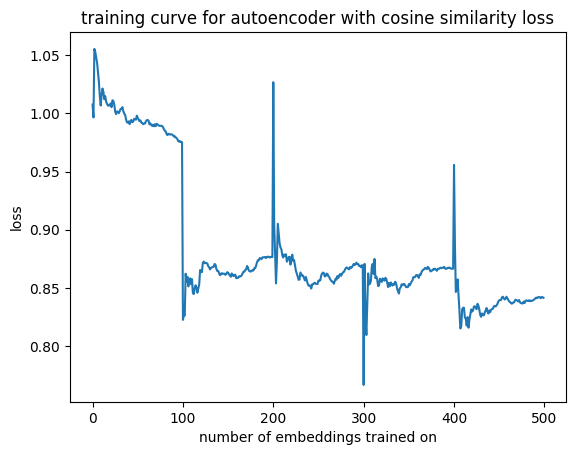

In [45]:
plt.plot(np.arange(len(cos_losses)) * batch_size * update_interval, cos_losses)
plt.title("training curve for autoencoder with cosine similarity loss")
plt.xlabel("number of embeddings trained on")
plt.ylabel("loss")
plt.show()

In [42]:
autoencoder = Autoencoder((13,300), 900)

# Define the loss function and optimizer
loss_function = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
n_epochs = 5
update_interval = 1
trained_autoencoder_mse, lossesMse = autoencoder_training(autoencoder, loss_function, optimizer, subset_dataloader, n_epochs, update_interval)

Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 10
Batch 11
Batch 12
Batch 13
Batch 14
Batch 15
Batch 16
Batch 17
Batch 18
Batch 19
Batch 20
Batch 21
Batch 22
Batch 23
Batch 24
Batch 25
Batch 26
Batch 27
Batch 28
Batch 29
Batch 30
Batch 31
Batch 32
Batch 33
Batch 34
Batch 35
Batch 36
Batch 37
Batch 38
Batch 39
Batch 40
Batch 41
Batch 42
Batch 43
Batch 44
Batch 45
Batch 46
Batch 47
Batch 48
Batch 49
Batch 50
Batch 51
Batch 52
Batch 53
Batch 54
Batch 55
Batch 56
Batch 57
Batch 58
Batch 59
Batch 60
Batch 61
Batch 62
Batch 63
Batch 64
Batch 65
Batch 66
Batch 67
Batch 68
Batch 69
Batch 70
Batch 71
Batch 72
Batch 73
Batch 74
Batch 75
Batch 76
Batch 77
Batch 78
Batch 79
Batch 80
Batch 81
Batch 82
Batch 83
Batch 84
Batch 85
Batch 86
Batch 87
Batch 88
Batch 89
Batch 90
Batch 91
Batch 92
Batch 93
Batch 94
Batch 95
Batch 96
Batch 97
Batch 98
Batch 99
Epoch 1/5, Loss: 0.3332
Batch 0
Batch 1
Batch 2
Batch 3
Batch 4
Batch 5
Batch 6
Batch 7
Batch 8
Batch 9
Batch 

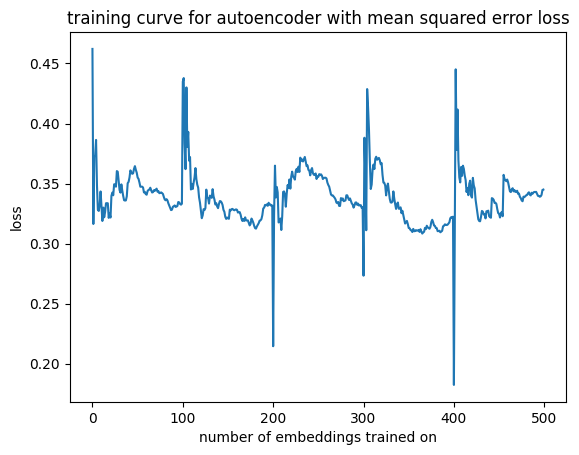

In [43]:
plt.plot(np.arange(len(lossesMse)) * batch_size * update_interval, lossesMse)
plt.title("training curve for autoencoder with mean squared error loss")
plt.xlabel("number of embeddings trained on")
plt.ylabel("loss")
plt.show()

### Testing mathematically driven compression techniques for embeddings

In [17]:
# function that takes in a list of embeddings and returns the average embedding for the sentences.

def average_embedding(embeddings):
    average_embedding = torch.mean(embeddings, dim=0)
    return average_embedding

In [161]:
def averageVectorToText(avg_embedding, word2vec_model):
    # Normalize the average embedding to have unit length
    avg_vector = avg_embedding[0, :].detach().numpy()
    normalized_avg_embedding = avg_vector / np.linalg.norm(avg_vector)

    try:
        # Find the most similar word to the given normalized vector
        similar_word = word2vec_model.most_similar(positive=[normalized_avg_embedding], topn=10)
        return similar_word
    except KeyError:
        # If the normalized vector doesn't correspond to any word, append error message
        return "UNKNOWN_WORD"

In [174]:
# example sentence with different types of animals

# example sentence of 30 animals

example_sent_50 = "cat dog tiger lion bear elephant cow horse pig sheep goat deer kangaroo koala panda sloth raccoon squirrel beaver otter seal walrus dolphin whale"

example_sent1_vector = textToVectors(example_sent_50, word2vec_model)

result_avg_embedding = average_embedding(torch.tensor(example_sent1_vector).float())

print(result_avg_embedding.shape)

print(result_avg_embedding.view(1, 300).shape)

words = averageVectorToText(result_avg_embedding.view(1, 300), word2vec_model)

best_word = ""
best_words = []

for word in words:
    if word[0] in example_sent_50:
        continue
    else:
        best_word = word[0]
        break

for word in words:
    if word[0] in example_sent_50:
        continue
    else:
        best_words.append(word[0])

print(words)
print(best_words)
print(best_word)

# adding the "words" to the sentence produces a best word which gets us closer to general words
# adding words to our sentence that are not in the sentence produces the next word that was present in the non-sentences words.
# try it yourself:
# Print best_words - add single word each time to sentence and you end up with the best word which is the next word in this array.


torch.Size([300])
torch.Size([1, 300])
[('rabbit', 0.7577382326126099), ('squirrel', 0.7297917604446411), ('otter', 0.7278611660003662), ('cat', 0.7210001349449158), ('tiger', 0.7206421494483948), ('elephant', 0.716738760471344), ('animal', 0.7096478939056396), ('critter', 0.7059867978096008), ('mammal', 0.6978620886802673), ('rhino', 0.6911106109619141)]
['rabbit', 'animal', 'critter', 'mammal', 'rhino']
rabbit


In [193]:
# example sentence of 20 birds
# giving a diverse enough examples in input sentence produces good embeddings. 

# example set of sports

example_sent_20 = "cricket volleyball softball rugby golf swimming diving gymnastics skiing snowboarding skateboarding surfing"

example_sent20_vector = textToVectors(example_sent_20, word2vec_model)

result_avg_embedding = average_embedding(torch.tensor(example_sent20_vector).float())

words = averageVectorToText(result_avg_embedding.view(1, 300), word2vec_model)

best_word = ""
best_words = []

for word in words:
    if word[0] in example_sent_20:
        continue
    else:
        best_word = word[0]
        break

for word in words:
    if word[0] in example_sent_20:
        continue
    else:
        best_words.append(word[0])

print(words)
print(best_words)
print(best_word)

[('swimming', 0.7066912651062012), ('snowboarding', 0.7025270462036133), ('volleyball', 0.6978116035461426), ('gymnastics', 0.6871929168701172), ('skiing', 0.6833471059799194), ('tennis', 0.6817452907562256), ('softball', 0.6762983798980713), ('water_polo', 0.6740932464599609), ('soccer', 0.665442943572998), ('basketball', 0.6534416675567627)]
['tennis', 'water_polo', 'soccer', 'basketball']
tennis
